<h1><center>CDMO Project (Lockdown Optimisation)</center></h1>
<center>The objective of this project is to demonstrate the application of non-linear programming in the analysis of lockdown policies during the COVID pandemic. The project aims to answer questions regarding the feasibility and optimisation of such policies.</center>
<br>

<h3><center>By: Gee Jun Hui Leonidas Yunani</center></h3>
<center>Email: leonidas.gee@studio.unibo.it</center>
<center>Academic Year: 2020 / 2021</center>

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from scipy.optimize import minimize
from sympy.solvers import solve
from sympy import symbols, Eq

## Data Import

The [dataset](https://ourworldindata.org/coronavirus-source-data) used is provided by Our World In Data and is regularly updated throughout the COVID-19 pandemic. For this project, the latest infection and stay at home policy datasets are used. The datasets are imported, preprocessed and merged for subsequent data visualisation.

In [2]:
# Load the infection dataset
infection = pd.read_csv('dataset/owid-covid-data.csv')
infection = infection[['continent', 'location', 'date', 
                       'new_cases_smoothed', 'reproduction_rate']]
infection.rename({'location': 'country'}, axis=1, inplace=True)

# Preview the infection dataset
print('Number of rows and columns: {}'.format(infection.shape))
infection.head()

Number of rows and columns: (92127, 5)


,continent,country,date,new_cases_smoothed,reproduction_rate
0,Asia,Afghanistan,2020-02-24,NaN,NaN
1,Asia,Afghanistan,2020-02-25,NaN,NaN
2,Asia,Afghanistan,2020-02-26,NaN,NaN
3,Asia,Afghanistan,2020-02-27,NaN,NaN
4,Asia,Afghanistan,2020-02-28,NaN,NaN


### Stay-at-Home Restrictions

Countries are grouped into four categories:
- No measures
- Recommended not to leave the house
- Required to not leave the house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips
- Required to not leave the house with minimal exceptions (e.g. allowed to leave only once every few days, or only one person can leave at a time, etc.)

There may be subnational or regional differences in restrictions. The policy categories shown may not apply at all subnational levels. A country is coded as having these restrictions if at least some subnational regions have implemented them.

In [3]:
# Load the stay at home policy dataset
home = pd.read_csv('dataset/stay-at-home-covid.csv')
home = home[['Entity', 'Day', 'stay_home_requirements']]
home.rename({'Entity': 'country', 'Day': 'date', 'stay_home_requirements': 'stay_home'}, axis=1, inplace=True)

# Preview the stay at home policy dataset
print('Number of rows and columns: {}'.format(home.shape))
home.head()

Number of rows and columns: (93584, 3)


,country,date,stay_home
0,Afghanistan,2020-01-01,0
1,Afghanistan,2020-01-02,0
2,Afghanistan,2020-01-03,0
3,Afghanistan,2020-01-04,0
4,Afghanistan,2020-01-05,0


In [4]:
# Merge the datasets based on country and date
common = infection.merge(home, on=['country','date'])
common = common.dropna()
common.reset_index(drop=True, inplace=True)
print('Number of rows and columns: {}'.format(common.shape))

Number of rows and columns: (68452, 6)


In [5]:
# Preview the merged dataset of a specific country
data = common.loc[common['country'] == 'Italy'].copy()
data.reset_index(drop=True, inplace=True)
print('Number of rows and columns: {}'.format(data.shape))
data.head()

Number of rows and columns: (459, 6)


,continent,country,date,new_cases_smoothed,reproduction_rate,stay_home
0,Europe,Italy,2020-02-24,32.286,3.55,2
1,Europe,Italy,2020-02-25,45.571,3.51,2
2,Europe,Italy,2020-02-26,64.286,3.44,2
3,Europe,Italy,2020-02-27,93.143,3.36,2
4,Europe,Italy,2020-02-28,124.000,3.25,2


In [6]:
# Define the 14-day changes plotting function
def show_14(X1, N1, X2, N2, X3, N3):
    dates = mdates.date2num(data['date'])

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    p1, = ax1.plot_date(dates, data[X1], '-', color='black', label=N1)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax1.set_ylabel(N1)

    p2, = ax2.plot_date(dates, data[X2], '-', color='red', label=N2)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax2.set_ylabel(N2) 

    p3, = ax3.plot_date(dates, data[X3], '-', color='blue', label=N3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax3.set_ylabel(N3)     
    ax3.spines['right'].set_position(('outward', 60))
    
    lns = [p1, p2, p3]
    ax1.legend(handles=lns, loc='best')
    
    fig.suptitle('14-day Changes of {}, {} and {}'.format(N1, N2, N3))
    fig.autofmt_xdate()
    ax1.xaxis.grid(True)
    plt.show()

## Data Visualisation

After merging the data and drilling down into data for Italy specifically, we can observe how the severity of the stay home policy influences the number of new cases and R-number. 

In early March 2020, as the pandemic was picking up speed in Italy, the Italian government brought stay home policy restrictions to their highest level of 3. This helped to squash the number of new cases and R-number to below 5000 and 1 respectively.

However, as the situation improved, the Italian government decided to reduce the severity of the lockdown greatly, at one point even reaching a state of no measures in early August 2020 until late October 2020.

This laxed policy would eventually lead to a sharp rise in new cases and the R-number, which would prompt the Italian government to enforce a stricter stay home policy in late October 2020 until the present.

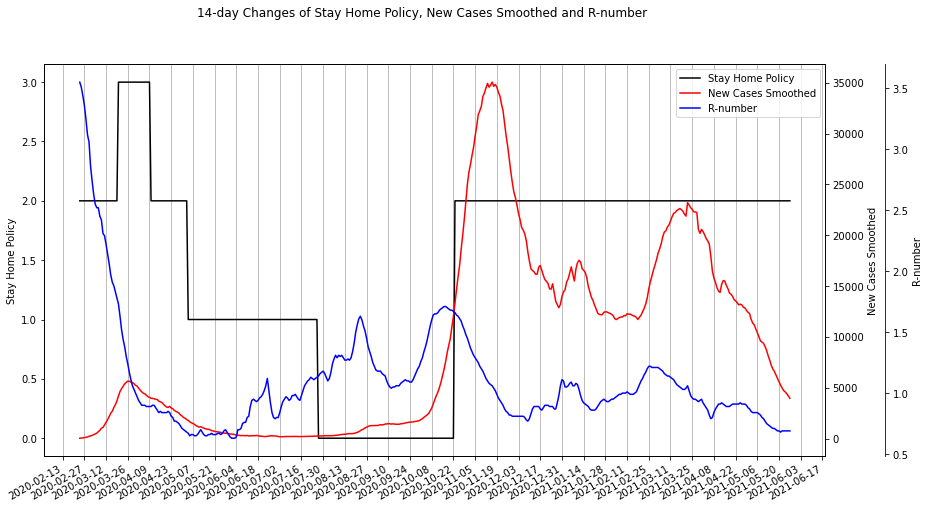

In [7]:
# Show the 14-day changes in the R-number due to the stay home policy
show_14('stay_home', 'Stay Home Policy', 
        'new_cases_smoothed', 'New Cases Smoothed', 
        'reproduction_rate', 'R-number')

## Constrained optimisation

### Formulation of the Objective Function

The objective function is formulated to related the number of lockdown days, D to the severity of the stay home policy, H and the reproduction rate, R. D is inversely proportional to H and R given a coefficient, m.

$$D = \frac{m}{H * R}$$

where:
- **D** is the **number of lockdown days**
- **m** is the **coefficient**
- **H** is the **severity of stay home policy**
- **R** is the **reproduction rate**

In [8]:
# Calculate the number of days for each stay home period
for i, row in data.iterrows():
    if i == 0:
        data.loc[i, 'days'] = 1
    else:
        if data.loc[i, 'stay_home'] == data.loc[i-1, 'stay_home']:
            data.loc[i, 'days'] = data.loc[i-1, 'days'] + 1
        elif data.loc[i, 'stay_home'] != data.loc[i-1, 'stay_home']:
            data.loc[i, 'days'] = 1            
            
# Preview the days column
data['days'] = pd.to_numeric(data['days'], downcast='integer')
data.tail()

,continent,country,date,new_cases_smoothed,reproduction_rate,stay_home,days
454,Europe,Italy,2021-05-23,4723.000,0.69,2,213
455,Europe,Italy,2021-05-24,4585.143,0.69,2,214
456,Europe,Italy,2021-05-25,4409.571,0.69,2,215
457,Europe,Italy,2021-05-26,4186.000,0.69,2,216
458,Europe,Italy,2021-05-27,3958.429,0.69,2,217


### Computing the Coefficient of the Objective Function

Gradient descent is used to compute the coefficient m from the dataset. The derivative of the cost function with respect to the coefficient m is first computed manually before being defined as a function for gradient descent.

$$𝐶 = \frac{SSE}{2𝑛}$$ 

$$SSE = Σᵢ(𝑦ᵢ − 𝑓(𝐱ᵢ))² = Σᵢ(𝑦ᵢ − Dᵢ)²$$

$$𝐶 = \frac{Σᵢ(𝑦ᵢ − \frac{m}{Hᵢ * Rᵢ})²}{2𝑛}$$

$$\frac{∂𝐶}{∂m} = \frac{1}{𝑛} Σᵢ(\frac{\frac{m}{Hᵢ * Rᵢ} - 𝑦ᵢ}{Hᵢ * Rᵢ}) = mean(\frac{\frac{m}{Hᵢ * Rᵢ} - 𝑦ᵢ}{Hᵢ * Rᵢ})$$

In [9]:
# Define the gradient of the cost function
def gradient(X, y, param):
    # +1 to prevent division by zero
    return np.mean((param[0] / (X[0] * X[1] + 1) - y) / (X[0] * X[1] + 1))

In [10]:
# Function to create a list of mini-batches
def getBatches(X, y, batch_size):
    mini_batches = []
    
    # Shuffle the data randomly
    data = np.concatenate((np.array(X), np.array(y))).T
    np.random.shuffle(data)
    
    n_obs = data.shape[0]
    for start in range(0, n_obs, batch_size):
        stop = start + batch_size
        x_batch, y_batch = data[start:stop, :-1], data[start:stop, -1:]
        mini_batches.append((x_batch, y_batch))
        
    return mini_batches

In [11]:
# Define the gradient descent function
def MBGD(gradient, X, y, solution, alpha, gamma, n_iter=2000, batch_size=20):
    step_size = 0
    
    for _ in range(n_iter):
        mini_batches = getBatches(X, y, batch_size)
        
        for mini_batch in mini_batches:
            X_mini, y_mini = mini_batch
            
            # Calculate the step using the gradient
            step_size = alpha * gradient(X_mini, y_mini, solution) + gamma * step_size

            # Update the parameters using the step
            solution -= step_size
        
    return solution

In [12]:
# Initialise the values for x and y
days = data['days'].values
policy = data['stay_home'].values
rate = data['reproduction_rate'].values

# Compute the coefficient m using gradient descent
m = MBGD(gradient, X=[policy, rate], y=[days], solution=[1], 
         alpha=0.1, gamma=0.9)
print('m = {}'.format(m[0]))

m = 108.74017345162828


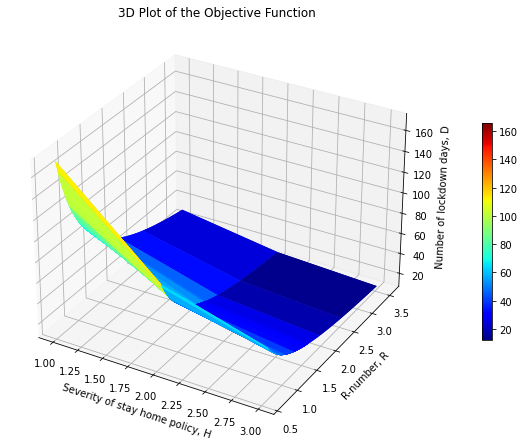

In [13]:
# Preview the 3D plot of the objective function with the found coefficient m
def f(H, R):
    return m / (H * R)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(policy[policy != 0], rate[rate != 0])
zs = np.array([f(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

surf = ax.plot_surface(X, Y, Z, cmap='jet')
ax.set_title('3D Plot of the Objective Function')
ax.set_xlabel('Severity of stay home policy, H')
ax.set_ylabel('R-number, R')
ax.set_zlabel('Number of lockdown days, D')
fig.colorbar(surf, shrink=0.5, pad=0.1)

plt.show()

### Constrained Optimisation of the Objective Function

The objective function can now be optimised using constraints to answer questions regarding the  trajectory of certain lockdown policies. This is done using two alternative methods, namely the quasi-Newton method with scipy or Lagrange multipliers with simpy.

### Question 1: Are politicians realistic in calling for a light and short lockdown?

The equation is satisfied with the constraints of **D ≤ 14**, **H ≤ 2** and **R ≤ 1**. This is to find if it is possible to have a light lockdown in only two weeks to bring the R-number to a value of 1 or less.

#### Implementation using scipy and the quasi-Newton method

In [14]:
# Define the model of the objective function
def f(x):
    return m / (x[0] * x[1])

In [15]:
# Define the list of constraints
def constraint_1(x):
    return -x[0] + 14 # Number of lockdown days must be less than or equal to 14

def constraint_2(x):
    return -x[1] + 2 # Severity of stay home policy must be less than or equal to 2

cons = ({'type': 'ineq', 'fun': constraint_1}, 
        {'type': 'ineq', 'fun': constraint_2})

In [16]:
# Define the initial point and bounds of the variables
x0 = np.array([1, 1])
bnds = ((0, None), (0, 3))

# Optimise the function and search for a solution
res = minimize(f, x0, constraints=cons, bounds=bnds, method='SLSQP')

# Print the value of D, H and R
print('Optimisation using the quasi-Newton method\n')
print('Value of R = {}'.format(round(res.fun[0])))
print('Value of D = {}'.format(round(res.x[0])))
print('Value of H = {}'.format(round(res.x[1])))

# Print satisfaction if R <= 1
if round(res.fun[0]) > 0:
    print('\nInequality constraints not satisfied as R > 1')
else:
    print('\nInequality constraints satisfied as R <= 1')

Optimisation using the quasi-Newton method

Value of R = 4
Value of D = 14
Value of H = 2

Inequality constraints not satisfied as R > 1


We can observe that implementing a stay home policy of 2 or less in severity for a period of 14 days will only lead to a minimum R-number of 2. Such a value remains dangerously high as it means that a person can still infect 2 people at a time.

#### Implementation using simpy and Lagrange multipliers

The full suite of KKT conditions required to be at a local optimum is:

1. $$L(x, λ_{1}, λ_{2}) = f(x) + λ_{1}g_{1}(x) + λ_{2}g_{2}(x)$$
<br>
$$L(x, λ_{1}, λ_{2}) = -mD^{-1}H^{-1} + λ_{1}(D - 14) + λ_{2}(H - 2)$$
<br>
<font color='red'>$$\frac{∂L}{∂D} = -mD^{-2} + λ_{1}$$</font>
<br>
<font color='red'>$$\frac{∂L}{∂H} = -mH^{-2} + λ_{2}$$</font>
<br>

2. $$D ≤ 14$$
$$H ≤ 2$$
<br>

3. $$g_{1}(x) = 0 \text{ and } g_{2}(x) = 0$$
<br>
<font color='red'>$$D + K_{1} - 14 = 0$$</font>
<font color='red'>$$H + K_{2} - 2 = 0$$</font>
<br>

4. $$λ_{1} ≥ 0 \text{ and } λ_{2} ≥ 0$$
<br>

5. $$λ_{1}g_{1}(x) = 0 \text{ and } λ_{2}g_{2}(x) = 0$$
<br>
<font color='red'>$$λ_{1}D - 14λ_{1} = 0$$</font>
<font color='red'>$$λ_{2}H - 2λ_{2} = 0$$</font>

In [17]:
D, H = symbols('D H', nonnegative=True)
L1, L2 = symbols('L1 L2', nonnegative=True)
K1, K2 = symbols('K1 K2')

sol = solve([Eq(-m[0] * (D ** -2) + L1, 0), 
             Eq(-m[0] * (H ** -2) + L2, 0), 
             Eq(D + K1 - 14, 0), 
             Eq(H + K2 - 2, 0), 
             Eq(D * L1 - 14 * L1, 0), 
             Eq(H * L2 - 2 * L2, 0)], 
            [D, H, L1, L2, K1, K2])

In [18]:
opt_D = int(sol[0][0])
opt_H = int(sol[0][1])
min_R = f([opt_D, opt_H])

# Print the value of D, H and R
print('Optimisation using Lagrange multipliers\n')
print('Value of R = {}'.format(round(min_R[0])))
print('Value of D = {}'.format(opt_D))
print('Value of H = {}'.format(opt_H))

# Print satisfaction if R <= 1
if min_R[0] > 0:
    print('\nInequality constraints not satisfied as R > 1')
else:
    print('\nInequality constraints satisfied as R <= 1')

Optimisation using Lagrange multipliers

Value of R = 4
Value of D = 14
Value of H = 2

Inequality constraints not satisfied as R > 1


### Question 2: How many days are required for lifting a strict lockdown?

The variable D is minimised with constraints on **H ≥ 2** and **R ≤ 1**. This is to find the minimum number of days that is required before a strict lockdown can be lifted in order to reach a R-number of less than 1.

#### Implementation using scipy and the quasi-Newton method

In [19]:
# Define the model of the objective function
def f(x):
    return m / (x[0] * x[1])

In [20]:
# Define the list of constraints
def constraint_1(x):
    return x[0] - 2 # Severity of stay home policy must be greater than or equal to 2

def constraint_2(x):
    return -x[1] + 1 # R-number must be less than or equal to 1

cons = ({'type': 'ineq', 'fun': constraint_1}, {'type': 'ineq', 'fun': constraint_2})

In [21]:
# Define the initial point and bounds of the variables
x0 = np.array([1, 1])
bnds = ((0, 3), (0, None))

# Optimise the function and search for a solution
res = minimize(f, x0, constraints=cons, bounds=bnds, method='SLSQP')

# Print the value of D, H and R
print('Optimisation using the quasi-Newton method\n')
print('Value of D = {}'.format(round(res.fun[0])))
print('Value of H = {}'.format(round(res.x[0])))
print('Value of R = {}'.format(round(res.x[1])))

Optimisation using the quasi-Newton method

Value of D = 36
Value of H = 3
Value of R = 1


We can observe that if a stricter stay home policy of 2 or greater is implemented, a R number of 1 can theoretically be reached in 22 days at minimum. Hence, for a shorter lockdown period, a stricter stay home policy must be implemented.

#### Implementation using simpy and Lagrange multipliers

The full suite of KKT conditions required to be at a local optimum is:

1. $$L(x, λ_{1}, λ_{2}, λ_{3}) = f(x) + λ_{1}g_{1}(x) + λ_{2}g_{2}(x) + λ_{3}g_{3}(x)$$
<br>
$$L(x, λ_{1}, λ_{2}, λ_{3}) = -mH^{-1}R^{-1} + λ_{1}(-H + 2) + λ_{2}(H - 3)+ λ_{3}(R - 1)$$
<br>
<font color='red'>$$\frac{∂L}{∂H} = -mH^{-2} - λ_{1} + λ_{2}$$</font>
<br>
<font color='red'>$$\frac{∂L}{∂R} = -mR^{-2} + λ_{3}$$</font>
<br>

2. $$H ≥ 2$$
$$H ≤ 3$$
$$R ≤ 1$$
<br>

3. $$g_{1}(x) = 0 \text{ and } g_{2}(x) = 0 \text{ and } g_{3}(x) = 0$$
<br>
<font color='red'>$$-H + K_{1} + 2 = 0$$</font>
<font color='red'>$$H + K_{2} - 3 = 0$$</font>
<font color='red'>$$R + K_{3} - 1 = 0$$</font>
<br>

4. $$λ_{1} ≥ 0 \text{ and } λ_{2} ≥ 0 \text{ and } λ_{3} ≥ 0$$
<br>

5. $$λ_{1}g_{1}(x) = 0 \text{ and } λ_{2}g_{2}(x) = 0 \text{ and } λ_{3}g_{3}(x) = 0$$
<br>
<font color='red'>$$-λ_{1}H + 2λ_{1} = 0$$</font>
<font color='red'>$$λ_{2}H - 3λ_{2} = 0$$</font>
<font color='red'>$$λ_{3}R - λ_{3} = 0$$</font>

In [22]:
H, R = symbols('H R', nonnegative=True)
L1, L2, L3 = symbols('L1 L2 L3', nonnegative=True)
K1, K2, K3 = symbols('K1 K2 K3')

sol = solve([Eq(-m[0] * (H ** -2) - L1 + L2, 0), 
             Eq(-m[0] * (R ** -2) + L3, 0), 
             Eq(-H + K1 + 2, 0), 
             Eq(H + K2 - 3, 0), 
             Eq(R + K3 - 1, 0), 
             Eq(-H * L1 + 2 * L1, 0), 
             Eq(H * L2 - 3 * L2, 0), 
             Eq(R * L3 - L3, 0)], 
            [H, R, L1, L2, L3, K1, K2, K3])

In [23]:
opt_H = int(sol[0][0])
opt_R = int(sol[0][1])
min_D = f([opt_H, opt_R])

# Print the value of D, H and R
print('Optimisation using Lagrange multipliers\n')
print('Value of D = {}'.format(round(min_D[0])))
print('Value of H = {}'.format(opt_H))
print('Value of R = {}'.format(opt_R))

Optimisation using Lagrange multipliers

Value of D = 36
Value of H = 3
Value of R = 1


## Conclusion

By utilising gradient descent and optimisation, it is shown that theoretically a light and short lockdown as advocated by politicians will not succeed in bringing down the R-number. Instead, a strict lockdown as advocated by scientist is required to achieve such goals.

It must also be acknowledged that the objective function is a simplified model of the COVID pandemic. A more complex function would provide for a better model in determining the feasibility and optimisation of lockdown policies.